# Maps API Examples

This notebook shows a few simple examples of retrieving data using the [Maps](https://docs.climateengine.com/docs/build/html/raster.html) (or 'raster') family of endpoints.  This group of endpoints is used to export raster maps (GeoTIFF and Earth Engine map IDs) and map statistics of datasets available in Climate Engine.

In each of these examples, the requested maps are exported to a Google Storage bucket using the raster/export/values endpoints.  These exported GeoTIFFs are downloaded to local storage and then plotted for quick visualization.

The CE API token is read as an environment variable named `CE_API_KEY`.  Additionally, Google Earth Engine credentials are read from a JSON account key, or from the system's `GOOGLE_APPLICATION_CREDENTIALS` environment variable.

Climate Engine \
February 2022

In [1]:
import datetime
import os
import requests
import time

import branca
import branca.colormap as cm
import ee
import folium
from folium import plugins
import json
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import rasterio
from rasterio.plot import show

In [2]:
requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)

In [3]:
# Set root URL for API requests
root_url = 'https://geodata.dri.edu/'

In [4]:
# Authentication info for the API
headers = {'Authorization': os.getenv('CE_API_KEY')}

In [5]:
# Initialize Google Earth Engine using a service account key
DEFAULT_SA_LOCATION = "/var/run/secret/cloud.google.com/service-account.json"
credentials = ee.ServiceAccountCredentials("_", key_file=os.getenv(
    'GOOGLE_APPLICATION_CREDENTIALS', DEFAULT_SA_LOCATION))
ee.Initialize(credentials)

In [6]:
# Google Storage bucket for storing output files
bucket_name = 'ce-demo-notebook-assets'

In [7]:
# Create function for getting task_id updates as raster jobs are submitted
def task_update(task_id):
    print(f"Processing task ID: {task_id}...")
    for i in range(0, 40):
        for j in range(1, 6):
            try:
                status = ee.data.getTaskStatus(task_id)[0]["state"]
                break
            except:
                print(f'Unable to get task status; retrying ({j}/5)')
                time.sleep(j ** 2)
                if j == 5:
                    print("Unable to get task status from EE.")
                    raise
                    
        if status == "COMPLETED":
            print(f"Export Successful!")
            break
        else:
            print(f"Still processing...{i * 30} seconds elapsed")
            time.sleep(30)

    if status == "FAILED":
        print(f"Failed to export task ID: {task_id}...")

In [8]:
# Load some basemaps for use in folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    )
}

## Vapor Pressure Deficit

In this example, the raster/export/values endpoint is used to generate an Earth Engine map ID and visualize average summer vapor pressure deficit (VPD) values in the southwestern United States. This example retrieves and reduces data from March - September 2021 to show the variation in median VPD across the region.  The VPD is a measure of the 'sponginess' of the atmosphere and can be used to predict the behavior of a potential wildfire, as well as playing a role in limiting the rate of plant growth.

The temporal statistic is applied over the specified date range to produce the map values.  Detailed documentation for the raster/export/values endpoint is found [here](https://docs.climateengine.com/docs/build/html/raster.html#rst-raster-export-values).

In [9]:
endpoint = 'raster/export/values'
vpd_bbox = [-128.5831, 31.3986, -112.7140, 43.0319]
# No need to include an extension on the export_filename below, .tif will be appended automatically.
vpd_export_filename = 'vpd_example_raster'

In [10]:
# Set up params dict for API call
params = {
    'dataset': 'G',
    'variable': 'vpd',
    'temporal_statistic': 'median',
    'start_date': '2021-03-01',
    'end_date': '2021-09-01',
    'bounding_box': f'{vpd_bbox}',
    'export_path': f'{bucket_name}/{vpd_export_filename}'
}

In [11]:
# Send API request
r = requests.get(root_url + endpoint, params=params, headers=headers, verify=False)
vpd_response = r.json()

In [12]:
# Get updates on task process
task_id = vpd_response['task_response']['id']
task_update(task_id)

Processing task ID: I2ZGACCBKDOQ27CGLTGROPYB...
Still processing...0 seconds elapsed
Still processing...30 seconds elapsed
Still processing...60 seconds elapsed
Still processing...90 seconds elapsed
Still processing...120 seconds elapsed
Still processing...150 seconds elapsed
Export Successful!


Download the raster to your local filesystem with the code snippet provided [here](https://docs.climateengine.com/docs/build/html/tutorials.html#downloading-files-from-google-bucket).

In [13]:
# Extract the data array and transform information for plotting
vpd_raster_file = fr'./tifs/{vpd_export_filename}.tif'
with rasterio.open(vpd_raster_file) as src:
    vpd_img = src.read(1)
    transform = src.meta['transform']

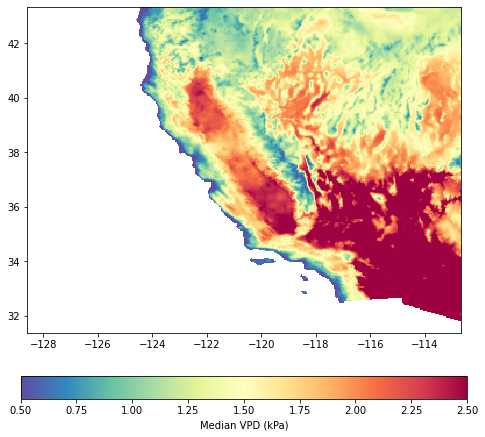

In [14]:
# Plot the VPD GeoTIFF
fig, ax = plt.subplots(figsize=(8, 8))
vmin = 0.5
vmax = 2.5
cmap = 'Spectral_r'

# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(vpd_img, 
                         cmap=cmap, 
                         vmin=vmin, 
                         vmax=vmax)
image = show(vpd_img, 
             transform=src.transform, 
             ax=ax, 
             cmap=cmap, 
             vmin=vmin, 
             vmax=vmax)

fig.colorbar(image_hidden,
             ax=ax,
             orientation='horizontal',
             label='Median VPD (kPa)',
             pad=0.1)

## NDVI Anomalies

In this example, the raster/export/anomalies endpoint is used to generate an Earth Engine map ID and visualize average NDVI anomalies for an agricultural region in Colorado. This example demonstrates the NDVI anomaly (or difference from average) during the summer of 2017, compared to the period between 2010 and 2021.  Regions of higher anomaly are above average during this period; similarly, lower anomaly regions have an NDVI that is below average for the specified date range.

The temporal statistic is applied over the specified date range to produce the map values.  Detailed documentation for the raster/export/anomalies endpoint is found [here](https://docs.climateengine.com/docs/build/html/raster.html#raster-export-anomalies).

In [15]:
endpoint = 'raster/export/anomalies'
ndvi_bbox = [-102.4, 40.1,-101.8, 40.4]
# Do not include an extension on the export_filename below, .tif will be appended automatically.
ndvi_export_filename = 'ndvi_anomalies_example_raster'

In [16]:
# Set up params dict for API call
params = {
    'dataset': 'LANDSAT_SR',
    'variable': 'NDVI',
    'temporal_statistic': 'mean',
    'calculation': 'anom',
    'start_date': '2017-05-01',
    'end_date': '2017-09-01',
    'start_year': '2010',
    'end_year': '2021',
    'bounding_box': f'{ndvi_bbox}',
    'export_path': f'{bucket_name}/{ndvi_export_filename}'
}

In [17]:
# Send API request
r = requests.get(root_url + endpoint, params=params, headers=headers, verify=False)
ndvi_response = r.json()

In [18]:
# Get updates on task process
task_id = ndvi_response['task_response']['id']
task_update(task_id)

Processing task ID: NIXSU3HSSYLAF7A2PPRENXBC...
Still processing...0 seconds elapsed
Still processing...30 seconds elapsed
Still processing...60 seconds elapsed
Still processing...90 seconds elapsed
Still processing...120 seconds elapsed
Still processing...150 seconds elapsed
Still processing...180 seconds elapsed
Still processing...210 seconds elapsed
Still processing...240 seconds elapsed
Still processing...270 seconds elapsed
Still processing...300 seconds elapsed
Still processing...330 seconds elapsed
Still processing...360 seconds elapsed
Still processing...390 seconds elapsed
Still processing...420 seconds elapsed
Still processing...450 seconds elapsed
Still processing...480 seconds elapsed
Still processing...510 seconds elapsed
Export Successful!


Download the raster to your local filesystem with the code snippet provided [here](https://docs.climateengine.com/docs/build/html/tutorials.html#downloading-files-from-google-bucket).

In [19]:
# Extract the data array and transform information for plotting
ndvi_raster_file = fr'./tifs/{ndvi_export_filename}.tif'
with rasterio.open(ndvi_raster_file) as src:
    ndvi_img = src.read(1)
    transform = src.meta['transform']

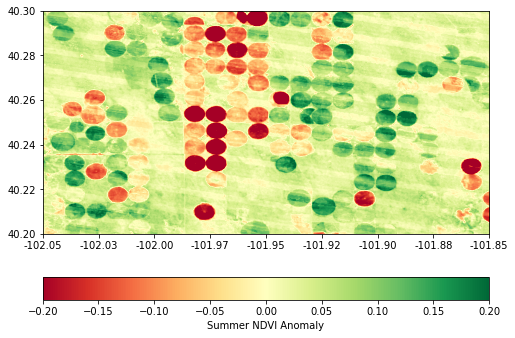

In [20]:
# Plot the NDVI GeoTIFF
fig, ax = plt.subplots(figsize=(8, 8))
vmin = -0.2
vmax = 0.2
cmap = 'RdYlGn'

# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(ndvi_img, 
                         cmap=cmap, 
                         vmin=vmin, 
                         vmax=vmax)
image = show(ndvi_img, 
             transform=src.transform, 
             ax=ax, 
             cmap=cmap, 
             vmin=vmin, 
             vmax=vmax)

ax.set_xlim([-102.05, -101.85])
ax.set_ylim([40.20, 40.30])
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

cbar = fig.colorbar(image_hidden, ax=ax, orientation='horizontal', label='Summer NDVI Anomaly', pad=0.1)

## Precipitation

In this example, the raster/export/values endpoint is used to export a map of total precipitation over a rectangular bounding box covering the state of Oregon for the year 2020. The underlying daily precipitation totals from gridMET are summed over the time period, and a raster (in GeoTIFF format) of these values is exported to a specified Google storage bucket.

The temporal statistic is applied over the specified date range to produce the map values.  Detailed documentation for the raster/export/values endpoint is found [here](https://docs.climateengine.com/docs/build/html/raster.html#raster-export-values).

In [21]:
endpoint = 'raster/export/values'
# Do not include an extension on the export_filename below, .tif will be appended automatically.
precip_export_filename = 'precip_example_raster'

In [22]:
# Set up params dict for API call
params = {
    'dataset': 'G',
    'variable': 'pr',
    'temporal_statistic': 'total',
    'start_date': '2020-01-01',
    'end_date': '2020-12-31',
    'bounding_box': f'[-124.7396, 42.0077, -116.401, 46.0268]',
    'export_path': f'{bucket_name}/{precip_export_filename}'
}

In [23]:
# Send API request
r = requests.get(root_url + endpoint, params=params, headers=headers, verify=False)
precip_resp = r.json()

In [24]:
# Get updates on task process
task_id = precip_resp['task_response']['id']
task_update(task_id)

Processing task ID: SKCAIIAGRLH6B3C6A33TEBUO...
Still processing...0 seconds elapsed
Still processing...30 seconds elapsed
Still processing...60 seconds elapsed
Still processing...90 seconds elapsed
Export Successful!


Download the raster to your local filesystem with the code snippet provided [here](https://docs.climateengine.com/docs/build/html/tutorials.html#downloading-files-from-google-bucket).

In [25]:
# Extract the data array and transform information for plotting
precip_raster_file = fr'./tifs/{precip_export_filename}.tif'
with rasterio.open(precip_raster_file) as src:
    precip_img = src.read(1)
    transform = src.meta['transform']

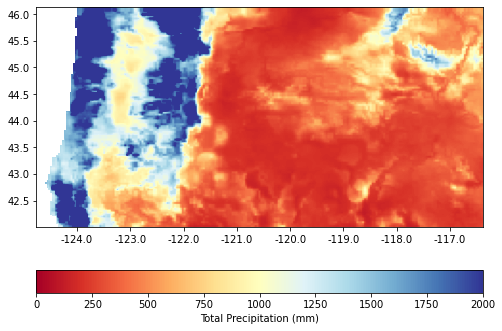

In [26]:
# Plot the precipitation GeoTIFF
fig, ax = plt.subplots(figsize=(8, 8))
vmin = 0
vmax = 2000
cmap = 'RdYlBu'

# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(precip_img, 
                         cmap=cmap, 
                         vmin=vmin, 
                         vmax=vmax)
image = show(precip_img, 
             transform=src.transform, 
             ax=ax, 
             cmap=cmap, 
             vmin=vmin, 
             vmax=vmax)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))


cbar = fig.colorbar(image_hidden, ax=ax, orientation='horizontal', label='Total Precipitation (mm)', pad=0.1)